In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pmdarima as pm
from numpy.random import seed
from scipy import stats
import statsmodels.api as sm

In [2]:
# Batman

In [3]:
Batma = pd.read_csv("Batman_Final.csv")
Batma = Batma[['Date', 'Units_Sold', 'Movie_Playing']]
Batma.head()

,Date,Units_Sold,Movie_Playing
0,1997-04,59706,0
1,1997-04,55389,0
2,1997-05,58451,0
3,1997-06,57641,1
4,1997-06,53416,1


In [4]:
Batma['Date'] = pd.to_datetime(Batma['Date'])

In [5]:
Batma.dtypes

Date             datetime64[ns]
Units_Sold                int64
Movie_Playing             int64
dtype: object

In [6]:
Batma.set_index('Date', inplace=True)
Batma.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-01,59706,0
1997-04-01,55389,0
1997-05-01,58451,0
1997-06-01,57641,1
1997-06-01,53416,1


In [7]:
Batma.index

DatetimeIndex(['1997-04-01', '1997-04-01', '1997-05-01', '1997-06-01',
               '1997-06-01', '1997-07-01', '1997-07-01', '1997-08-01',
               '1997-08-01', '1997-09-01',
               ...
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-11-01',
               '2019-11-01', '2019-11-01', '2019-11-01', '2019-12-01',
               '2019-12-01', '2019-12-01'],
              dtype='datetime64[ns]', name='Date', length=618, freq=None)

In [8]:
Batman = Batma.resample('M').mean()
Batman.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-30,57547.5,0.0
1997-05-31,58451.0,0.0
1997-06-30,55528.5,1.0
1997-07-31,53643.0,1.0
1997-08-31,55042.0,1.0


In [9]:
Batman.isnull().values.any()

True

In [10]:
Batman.isnull().sum().sum()

10

In [11]:
is_NaN = Batman.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = Batman[row_has_NaN]
print(rows_with_NaN)

            Units_Sold  Movie_Playing
Date                                 
2009-03-31         NaN            NaN
2009-05-31         NaN            NaN
2013-09-30         NaN            NaN
2014-09-30         NaN            NaN
2015-05-31         NaN            NaN


In [12]:
Batman = Batman.fillna(method='ffill')

In [13]:
Batman.isnull().values.any()

False

In [14]:
#Statistics

In [15]:
np.random.seed(47)
N_rep = 10000
#Create function to run bootstrap sampling from
def bootstrap(data, func, N_rep):
    #Create empty array 
    bootstrap_rep = np.empty(N_rep)
    #Run bootstrap replicates
    for i in range(N_rep):
        bootstrap_sample = np.random.choice(data, len(data))
        bootstrap_rep[i] = func(bootstrap_sample)
    return bootstrap_rep

In [16]:
#Assign movie and no-movie array
movie = np.array(Batman[Batman['Movie_Playing']==1].Units_Sold)
no_movie = np.array(Batman[Batman['Movie_Playing']==0].Units_Sold)
#Find difference in standard deviation between them
difference_std = np.std(movie) - np.std(no_movie)
difference_std

-1071.7084021773044

In [17]:
#Difference of 10000 replicates
bootstrap_std = bootstrap(movie, np.std, N_rep) - bootstrap(no_movie, np.std, N_rep)
#95% confidence interval
conf_interval = np.percentile(bootstrap_std,[2.5, 97.5])
conf_interval

array([-8304.60234587,  4569.98720684])

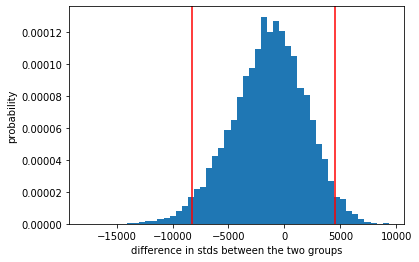

In [18]:
plt.hist(bootstrap_std, bins=50, density=True)
plt.axvline(conf_interval[0], color='red')
plt.axvline(conf_interval[1], color='red')
plt.xlabel('difference in stds between the two groups')
plt.ylabel('probability')
plt.show()

In [19]:
# We combine the two datasets to have equal means
combined_mean = np.mean(np.concatenate((movie, no_movie)))
#Adjusting the insured and non-insured arrays 
movie_adjusted = movie - np.mean(movie) + combined_mean
no_movie_adjusted = no_movie - np.mean(no_movie) + combined_mean

In [20]:
# Bootstrap replicates
bootstrap_movie_adjusted = bootstrap(movie_adjusted, np.mean, N_rep)
bootstrap_no_movie_adjusted = bootstrap(no_movie_adjusted, np.mean, N_rep)

In [21]:
# Differences from bootstrap
bootstrap_differences = bootstrap_movie_adjusted - bootstrap_no_movie_adjusted
# Difference from data
data_difference = np.mean(movie) - np.mean(no_movie)
data_difference

4137.306027281607

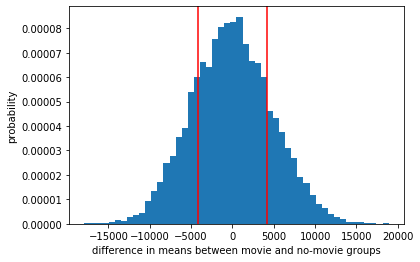

In [22]:
plt.hist(bootstrap_differences, bins=50, density=True)
plt.xlabel("difference in means between movie and no-movie groups")
plt.ylabel("probability")
plt.axvline(data_difference, color='r')
plt.axvline(-data_difference, color='r')
plt.show()

In [23]:
# P value
p_value = np.sum(bootstrap_differences >= data_difference)/ len(bootstrap_differences)
p_value

0.1929

In [24]:
stats.ttest_ind(movie, no_movie, equal_var = False)

Ttest_indResult(statistic=0.8449223894705583, pvalue=0.4033637001355216)

In [25]:
# Linear Regression

In [26]:
#Without Movie_Playing External Predictor

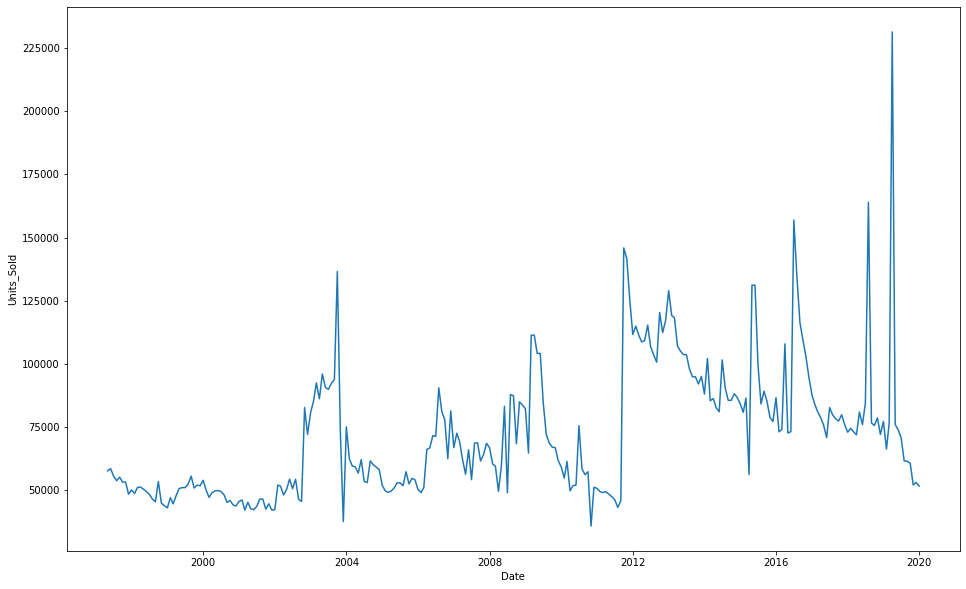

In [27]:
plt.figure(figsize=(16,10))
sns.lineplot(x=Batman.index, y=Batman.Units_Sold, data=Batman)

In [28]:
train = Batman.loc['1997-04-30':'2015-01-31']
test= Batman.loc['2015-02-28':]

In [29]:
train.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-30,57547.5,0.0
1997-05-31,58451.0,0.0
1997-06-30,55528.5,1.0
1997-07-31,53643.0,1.0
1997-08-31,55042.0,1.0


In [30]:
test.head()

,Units_Sold,Movie_Playing
Date,,
2015-02-28,86402.0,0.0
2015-03-31,56126.0,0.0
2015-04-30,131128.0,0.0
2015-05-31,131128.0,0.0
2015-06-30,99901.5,0.0


In [31]:
test_no_movie = Batman[['Units_Sold']]
test_no_movie = test_no_movie.loc['2015-02-28':]
train_no_movie = Batman[['Units_Sold']]
train_no_movie = train_no_movie.loc['1997-04-30':'2015-01-31']

In [32]:
train.shape

(214, 2)

In [33]:
test.shape

(59, 2)

In [34]:
#Find p, d, and q values to build ARIMA model
#P is the order of the Auto Regressive (AR) term or the number of lags of Y to be used as predictors
#D is the number of differencing required to make the time series stationary
#Q is the order of the Moving Average (MA) term or the number of lagged forecast errors that should go into the ARIMA model

In [35]:
#ARIMA

In [36]:
#Auto ARIMA Forecast to choose best p,d,q
model_train_arima = pm.auto_arima(train[['Units_Sold']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_arima.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=4641.073, BIC=4654.537, Time=0.042 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=4922.250, BIC=4928.982, Time=0.008 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=4648.059, BIC=4658.157, Time=0.022 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=4777.475, BIC=4787.573, Time=0.082 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=5395.535, BIC=5398.901, Time=0.005 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=4642.461, BIC=4659.291, Time=0.087 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=4641.137, BIC=4657.967, Time=0.048 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=4795.355, BIC=4808.819, Time=0.038 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=4643.220, BIC=4656.684, Time=0.031 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=4640.328, BIC=4660.524, Time=0.082 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercep

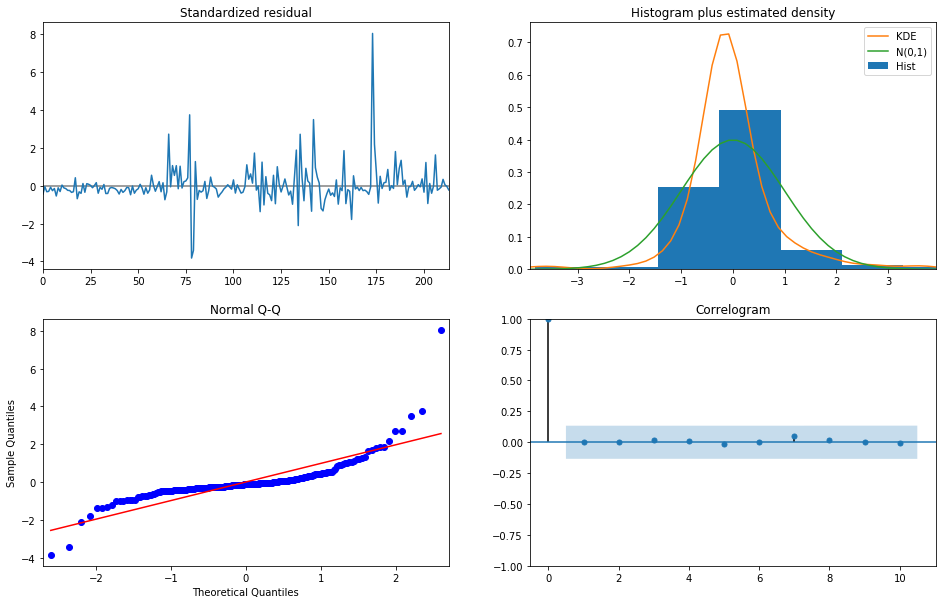

In [37]:
model_train_arima.plot_diagnostics(figsize=(16,10))
plt.show()

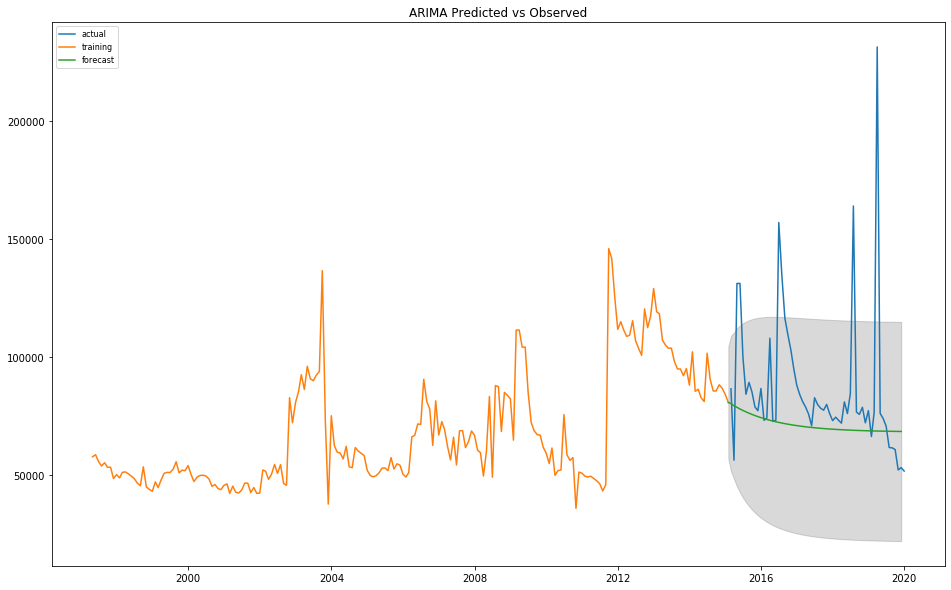

In [38]:
# Forecast
n_periods_arima = 59
fc_arima, confint_arima = model_train_arima.predict(n_periods=n_periods_arima, return_conf_int=True)
index_of_fc_arima = pd.date_range(train.index[-1], periods = n_periods_arima, freq='MS')

# make series for plotting purpose
fc_series_arima = pd.Series(fc_arima, index=index_of_fc_arima)
lower_series_arima = pd.Series(confint_arima[:, 0], index=index_of_fc_arima)
upper_series_arima = pd.Series(confint_arima[:, 1], index=index_of_fc_arima)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test_no_movie, label='actual')
plt.plot(train_no_movie, label='training')
plt.plot(fc_series_arima, label='forecast')
plt.fill_between(lower_series_arima.index, lower_series_arima, upper_series_arima, color='k', alpha=.15)
plt.title("ARIMA Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [39]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
mean_absolute_percentage_error(test_no_movie, fc_series_arima)

18.044019512739872

In [41]:
#SARIMA

In [42]:
#Auto SARIMA Forecast to choose best p,d,q
model_train_sarima = pm.auto_arima(train[['Units_Sold']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_sarima.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=4429.152, BIC=4445.669, Time=1.377 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=4517.239, BIC=4523.846, Time=0.025 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=4475.276, BIC=4488.489, Time=0.248 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=4402.261, BIC=4415.474, Time=1.351 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=4515.646, BIC=4518.949, Time=0.018 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=4509.404, BIC=4522.618, Time=0.204 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=4437.524, BIC=4457.344, Time=0.679 seconds
Fit ARIMA(1,1,1)x(0,1,2,12) [intercept=True]; AIC=4437.520, BIC=4457.340, Time=1.910 seconds
Fit ARIMA(1,1,1)x(1,1,0,12) [intercept=True]; AIC=447

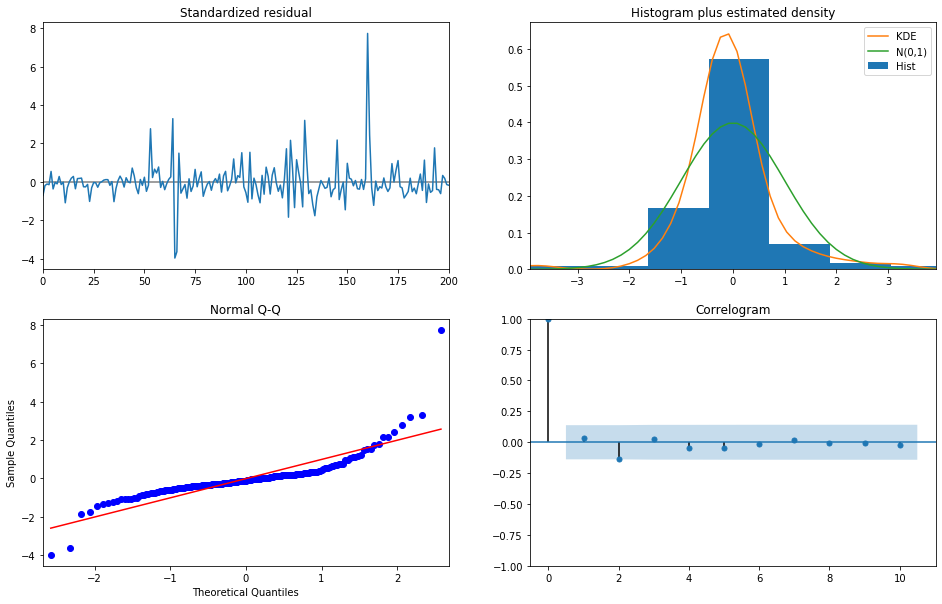

In [43]:
model_train_sarima.plot_diagnostics(figsize=(16,10))
plt.show()

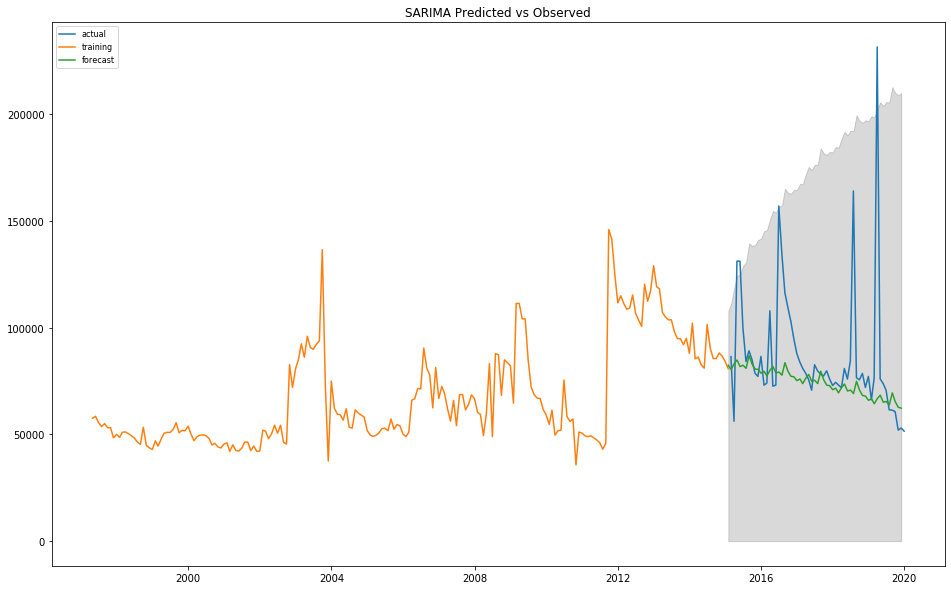

In [44]:
# Forecast
n_periods_sarima = 59
fc_sarima, confint_sarima = model_train_sarima.predict(n_periods=n_periods_sarima, return_conf_int=True)
index_of_fc_sarima = pd.date_range(train.index[-1], periods = n_periods_sarima, freq='MS')

# make series for plotting purpose
fc_series_sarima = pd.Series(fc_sarima, index=index_of_fc_sarima)
lower_series_sarima = pd.Series(confint_sarima[:, 0], index=index_of_fc_sarima)
upper_series_sarima = pd.Series(confint_sarima[:, 1], index=index_of_fc_sarima)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test_no_movie, label='actual')
plt.plot(train_no_movie, label='training')
plt.plot(fc_series_sarima, label='forecast')
plt.fill_between(upper_series_sarima.index, upper_series_sarima, color='k', alpha=.15)
plt.title("SARIMA Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [45]:
mean_absolute_percentage_error(test_no_movie, fc_series_sarima)

18.05778667442135

In [46]:
# With Movie_Playing External Predictor

In [47]:
#SARIMAX

In [48]:
#Auto SARIMAX Forecast to choose best p,d,q
model_train_sarimax = pm.auto_arima(train[['Units_Sold']], exogenous=train[['Movie_Playing']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_sarimax.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=4448.045, BIC=4467.894, Time=0.479 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=4698.680, BIC=4708.605, Time=0.042 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=4487.418, BIC=4503.959, Time=0.317 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=4553.050, BIC=4569.592, Time=0.421 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=5569.256, BIC=5575.872, Time=0.036 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=4525.359, BIC=4541.900, Time=0.150 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=4450.039, BIC=4473.196, Time=0.661 seconds
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=True]; AIC=4450.008, BIC=4473.166, Time=1.936 seconds
Fit ARIMA(1,0,1)x(1,1,0,12) [intercept=True]; AIC=4487.787, BIC=4507.637, Time=0.446 seconds
Fit ARIMA(1,0,1)x(1,1,2,12) [intercept=True]; AIC=4451.439, BIC=4477.906, Time=3.940 seconds
Fit ARIMA(1,0,0)x(0,1,1,12

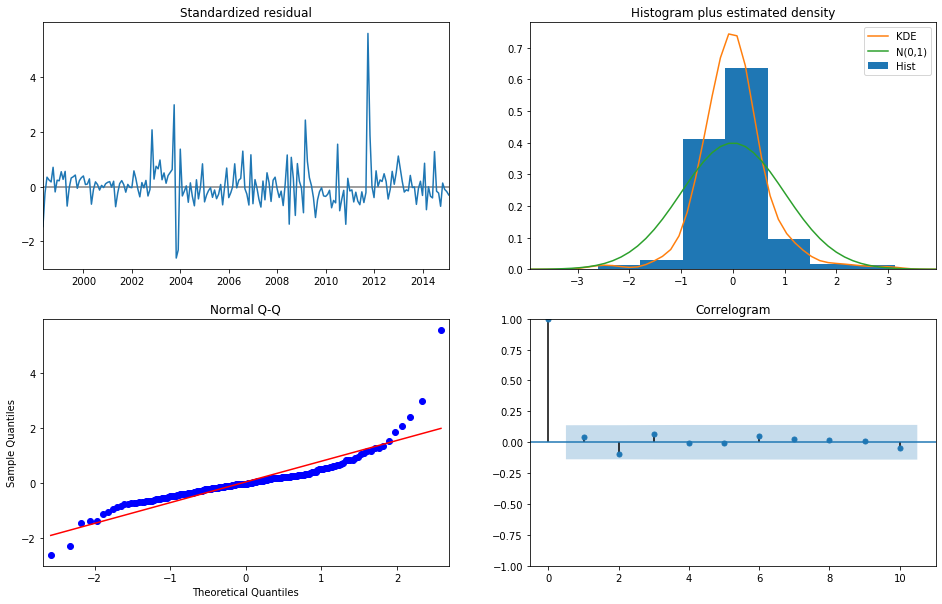

In [49]:
model_train_sarimax.plot_diagnostics(figsize=(16,10))
plt.show()

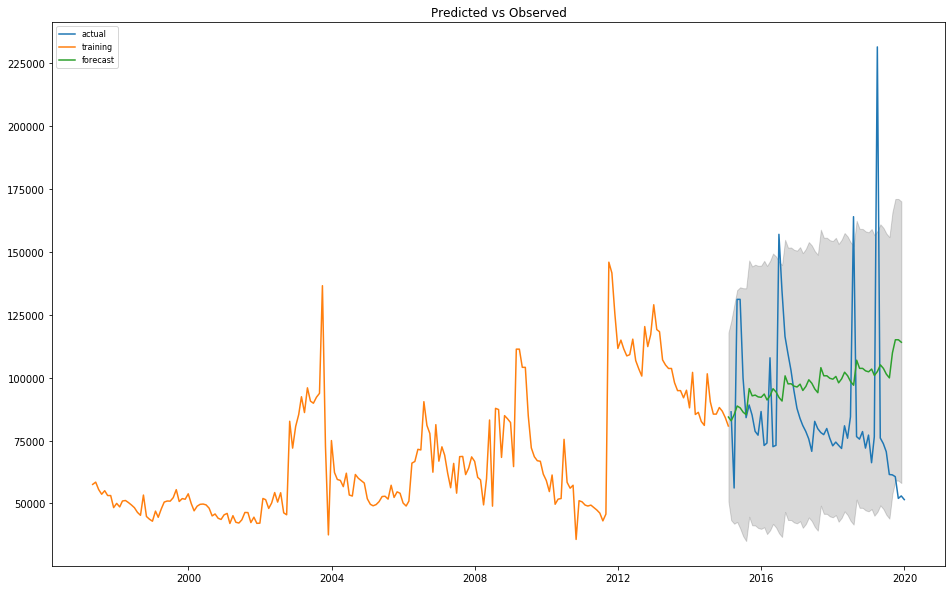

In [50]:
# Forecast
n_periods_sarimax = 59
fc_sarimax, confint_sarimax = model_train_sarimax.predict(n_periods=n_periods_sarimax, exogenous=test[['Movie_Playing']], 
                                                          return_conf_int=True)
index_of_fc_sarimax = pd.date_range(train.index[-1], periods = n_periods_sarimax, freq='MS')

# make series for plotting purpose
fc_series_sarimax = pd.Series(fc_sarimax, index=index_of_fc_sarimax)
lower_series_sarimax = pd.Series(confint_sarimax[:, 0], index=index_of_fc_sarimax)
upper_series_sarimax = pd.Series(confint_sarimax[:, 1], index=index_of_fc_sarimax)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test[['Units_Sold']], label='actual')
plt.plot(train[['Units_Sold']], label='training')
plt.plot(fc_series_sarimax, label='forecast')
plt.fill_between(lower_series_sarimax.index, lower_series_sarimax, upper_series_sarimax, color='k', alpha=.15)
plt.title("Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [51]:
mean_absolute_percentage_error(test_no_movie, fc_series_sarimax)

31.34217373198942